In [1]:
import requests
url = "https://mmsb.cnrs.fr/equipe/mobi/"

try:
    httpReq = requests.get(url, proxies=None)
except NameError:
    httpReq = requests.get(url)
ans = httpReq.text

In [9]:
import requests

paicquicProviderURL="http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search"
miqlMethod="query"
miqlField="pubid"
miqlValue="17446270"

miqlRequest= f"{paicquicProviderURL}/{miqlMethod}/{miqlField}:{miqlValue}"
print(miqlRequest)

try:
    httpReq = requests.get(miqlRequest)
except NameError:
    httpReq = requests.get(miqlRequest)
ans=httpReq.text

http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/pubid:17446270


In [19]:
import re

def mitabReader(httpText):
    for line in ans.split("\n"):
        _ = line.split("\t")
        if len(_) > 1 and _[0].startswith("uniprotkb:")\
                      and _[1].startswith("uniprotkb:"):
            yield [ _[0].replace("uniprotkb:", ""),\
                    _[1].replace("uniprotkb:", "") ]\
                  + _[2:]
                
            
def isMitab_EBV_EBV(mitabArray):
    reEBV = "taxid:(1037[6-7]|82830)"
    if re.search(reEBV, mitabArray[9]) and re.search(reEBV, mitabArray[10]):
        return True
    return False

def isMitab_Human_EBV(mitabLine):
    reHuman = "taxid:9606"
    reEBV = "taxid:(1037[6-7]|82830)"
    if re.search(reEBV, mitabArray[9]) and re.search(reHuman,mitabArray[10]) or re.search(reHuman, mitabArray[9]) and re.search(reEBV,mitabArray[10]):
        return True
    return False


EBV_EBV_mitab   = []
EBV_Human_mitab = []
total = 0
for mitabArray in mitabReader(ans):
    total += 1
    if isMitab_EBV_EBV(mitabArray):
        EBV_EBV_mitab.append(mitabArray)
    elif isMitab_Human_EBV(mitabArray):
        EBV_Human_mitab.append(mitabArray)
    else : 
        raise ValueError("Je ne connais pas cette espece ==> ", mitabArray[9:11])

print(f"Nombre d'interractions Human_EBV : {len(EBV_Human_mitab)}")
print(f"Nombre total d'interactions {total}, EBV-EBV {len(EBV_EBV_mitab)}")

Nombre d'interractions Human_EBV : 171
Nombre total d'interactions 230, EBV-EBV 59


In [20]:
ebv_prot = set()
for data in EBV_EBV_mitab:
    ebv_prot.add(data[0])
    ebv_prot.add(data[1])
print(f"{len(ebv_prot)} EBV protein")
    
human_prot = set()
for data in EBV_Human_mitab:
    human_prot.add(data[0])
    human_prot.add(data[1])
human_prot = human_prot - ebv_prot
print(f"{len(human_prot)} Human protein")

48 EBV protein
129 Human protein


In [31]:
import networkx as nx
import re
G = nx.Graph()

for psqDatum in EBV_EBV_mitab:
    G.add_edge(psqDatum[0], psqDatum[1])

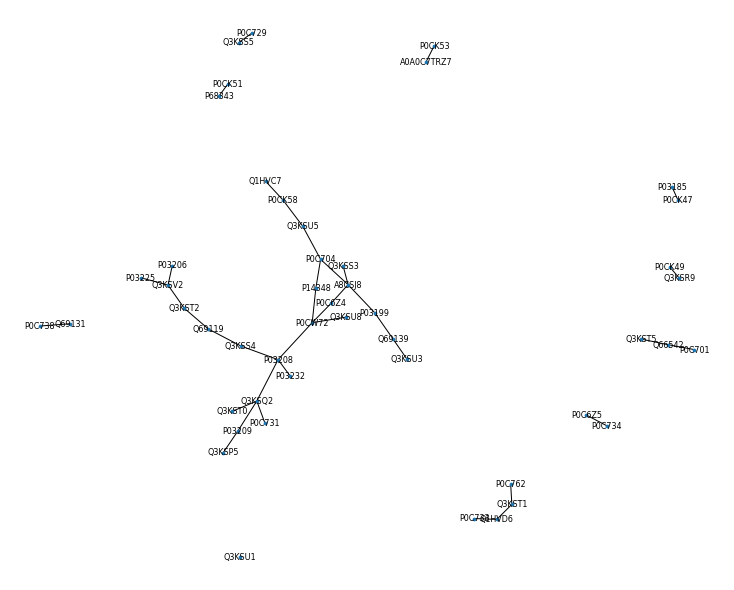

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
nx.draw(G, with_labels=True, node_size=3, font_size=8, linewidths=2)
plt.show()

In [36]:
from xml.etree.ElementTree import parse, dump, fromstring, register_namespace, ElementTree

# Utility functions
# Extracting All go terms relative to provided UNIPROT accessor
def goTerms(xmlEntry):
    ns = '{http://uniprot.org/uniprot}'
    goTerms = xmlEntry.findall(ns +'dbReference[@type="GO"]')
    goTermList = []
    for goT in goTerms:
        gID   = goT.attrib['id']
        gName = goT.find(ns +'property[@type="term"]').attrib['value']
        goTermList.append({"name" : gName, "ID" : gID})
    return goTermList

# Return information about provided UNIPROT accessor as python dictionary
def proteinDict(uniprotID, root):
    ns   = '{http://uniprot.org/uniprot}'

    data = { "accession" : uniprotID,
             "geneName" : None,
             "name" : None,
             "GOterms" : None
           }

    for entry in root.findall(ns+'entry'):
        accessions = entry.findall(ns+"accession")
        for acc in accessions:
            if acc.text == uniprotID: # entry is the node matching provided UNIPROT accessor
                e = entry.find(f"{ns}protein/{ns}recommendedName/{ns}fullName")
                if not e is None:
                    data["name"] = e.text
                e = entry.find(f"{ns}gene/{ns}name")
                if not e is None:
                    data["geneName"] = e.text

                data["GOterms"] = goTerms(entry)
                return data
    raise ValueError(f"{uniprotID} nor found in XML document")
    
#test
tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()
proteinDict("Q53Y88", root)

{'accession': 'Q53Y88',
 'geneName': 'GRN',
 'name': 'Progranulin',
 'GOterms': [{'name': 'C:azurophil granule lumen', 'ID': 'GO:0035578'},
  {'name': 'C:endoplasmic reticulum', 'ID': 'GO:0005783'},
  {'name': 'C:endosome', 'ID': 'GO:0005768'},
  {'name': 'C:extracellular exosome', 'ID': 'GO:0070062'},
  {'name': 'C:extracellular region', 'ID': 'GO:0005576'},
  {'name': 'C:extracellular space', 'ID': 'GO:0005615'},
  {'name': 'C:Golgi apparatus', 'ID': 'GO:0005794'},
  {'name': 'C:late endosome', 'ID': 'GO:0005770'},
  {'name': 'C:lysosomal membrane', 'ID': 'GO:0005765'},
  {'name': 'C:lysosome', 'ID': 'GO:0005764'},
  {'name': 'C:membrane', 'ID': 'GO:0016020'},
  {'name': 'C:plasma membrane', 'ID': 'GO:0005886'},
  {'name': 'C:trans-Golgi network', 'ID': 'GO:0005802'},
  {'name': 'F:chaperone binding', 'ID': 'GO:0051087'},
  {'name': 'F:cytokine activity', 'ID': 'GO:0005125'},
  {'name': 'F:growth factor activity', 'ID': 'GO:0008083'},
  {'name': 'F:RNA binding', 'ID': 'GO:0003723'},


In [40]:
tree = parse('./data/Calderwood_EBV_proteome.xml')
root = tree.getroot()

EBV_EBV_geneLabels = {}
for node in G.nodes():
    pDict = proteinDict(node, root)
    EBV_EBV_geneLabels[node] = pDict["geneName"] if pDict["geneName"] else str(node)
EBV_EBV_geneLabels

{'P0CW72': 'BARF1',
 'P0C704': 'MCP',
 'P14348': 'SCP',
 'P03185': 'NEC2',
 'P0CK47': 'NEC1',
 'P0C731': 'BGLF4',
 'Q3KSQ2': 'TK',
 'P0CK53': 'BGLF2',
 'A0A0C7TRZ7': 'BSLF1',
 'Q3KST5': 'BLRF2',
 'Q66542': 'BNRF1',
 'Q3KSS4': 'EBNA1',
 'P03209': 'BRLF1',
 'Q3KSP5': 'LF2',
 'Q3KSU8': 'BPLF1',
 'Q3KSU1': 'BMLF1',
 'Q3KSV2': 'EBNA2',
 'P03206': 'BZLF1',
 'Q3KST2': 'EBNA3',
 'P03225': 'BDLF2',
 'Q3KSU5': 'RIR1',
 'P0C729': 'LMP2',
 'Q3KSS5': 'BRRF2',
 'Q69119': 'Q69119',
 'Q3KST0': 'EBNA6',
 'P0CK58': 'BALF1',
 'P03208': 'BILF1',
 'Q69131': 'BN-LF2a',
 'P0C738': 'BNLF2a',
 'P0C701': 'RIR2',
 'Q1HVC7': 'BVRF2',
 'P0CK49': 'BSRF1',
 'Q3KSR9': 'BBRF1',
 'P0C734': 'BTRF1',
 'P0C6Z5': 'BZLF2',
 'Q3KSS3': 'gL',
 'A8CSJ8': 'LMP1',
 'P68343': 'BLLF1',
 'P0CK51': 'BBLF1',
 'P03199': 'BLLF2',
 'Q69139': 'Q69139',
 'P0C6Z4': 'gN',
 'Q3KSU3': 'BMRF1',
 'P03232': 'BXRF1',
 'Q3KST1': 'EBNA4',
 'P0C762': 'gB',
 'P0C733': 'BNLF2b',
 'Q1HVD6': 'TRX2'}

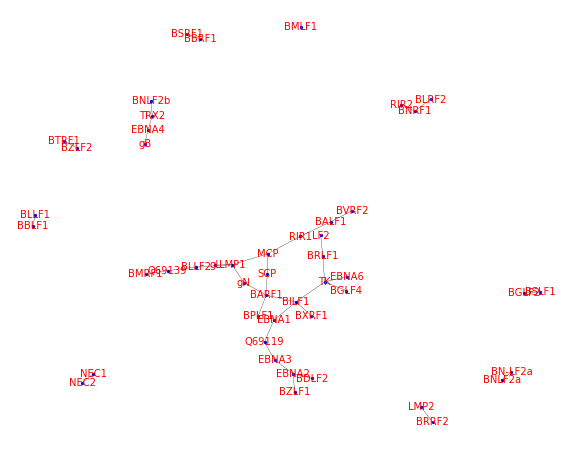

In [42]:
plt.figure(figsize=(10,8))
plt.axis('off')

pos=nx.spring_layout(G)

nx.draw_networkx_nodes(G,pos,node_size=5,node_color="blue")
nx.draw_networkx_labels(G,pos,EBV_EBV_geneLabels,font_size=10,font_weight=400,font_color='r')
nx.draw_networkx_edges(G,pos,width=0.3)
plt.show()

In [45]:
G2 = nx.Graph()
humanGeneLabels = {}
ebvGeneLabels = {}
reHuman = "taxid:9606"

for psqDatum in EBV_Human_mitab:
    (a, b) = (psqDatum[0],psqDatum[1])
    G2.add_edge(a,b)
    (a,b) = (a,b) if re.search(reHuman,psqDatum[9]) else (b,a)
    humanGeneLabels[a]=None
    ebvGeneLabels[b]=None

tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()
for humanID in humanGeneLabels.keys():
    pDict = proteinDict(humanID,root)
    humanGeneLabels[humanID] = pDict["geneName"] if pDict["geneName"] else humanID
    
tree = parse('./data/Calderwood_EBV_proteome.xml')
root = tree.getroot()
for ebvID in ebvGeneLabels.keys():
    pDict = proteinDict(ebvID,root)
    ebvGeneLabels[ebvID] = pDict["geneName"] if pDict["geneName"] else ebvID

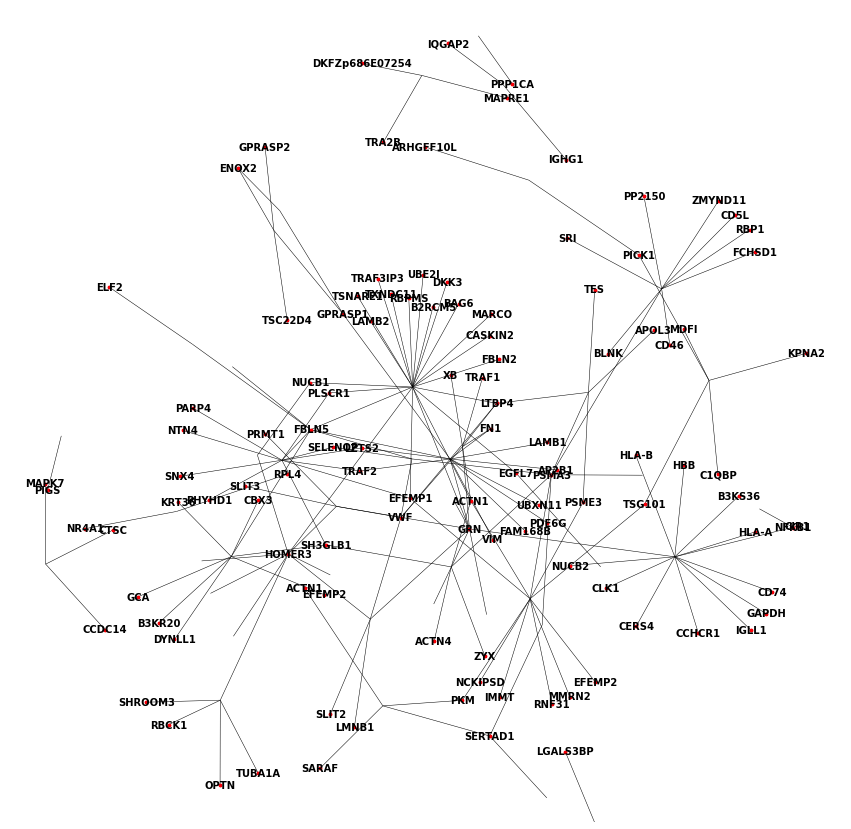

In [48]:
plt.figure(figsize=(15,15))
plt.axis('off')

#pos=nx.draw(G,with_labels=False)
pos=nx.spring_layout(G2,k=0.225)

nx.draw_networkx_nodes(G2,pos,node_size=8,node_color="blue",node_shape="s",nodelist=humanGeneLabels.keys())
nx.draw_networkx_nodes(G2,pos,node_size=8,node_color="red",node_shape="o",nodelist=humanGeneLabels.keys())
nx.draw_networkx_labels(G2,pos,humanGeneLabels,font_size=10,font_weight=800, font_color='black')
nx.draw_networkx_edges(G2,pos,width=0.5)

plt.show()